# Recurrent Neural Network

RNN（Recurrent Neural Network, 再帰型ニューラルネットワーク）

![](https://cdn-ak.f.st-hatena.com/images/fotolife/n/nkdkccmbr/20161006/20161006221349.png)  
RNNのイメージ 出典：[３層パーセプトロン -- ニューラルネットワーク・DeepLearningなどの画像素材　プレゼン・ゼミなどに【WTFPL】](https://nkdkccmbr.hateblo.jp/entry/2016/10/06/222245)

In [4]:
# packageのimport
from typing import Any, Union, Callable, Type, TypeVar
from tqdm.std import trange,tqdm
import numpy as np 
import numpy.typing as npt
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
plt.style.use("bmh")

# pytorch関連のimport
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader

## RNNとは

### RNNのイメージと再帰構造

RNNとは，時系列構造をもつデータをニューラルネットワークでうまく扱うことができる枠組みです．RNNというとネットワークの中に閉路があるだけでそれだと認識されるので，順伝搬において信号の伝搬路の中にループがあれば全てRNNと言われます．ここでは以下のようなネットワーク（エルマン型）を紹介します．  

> ![](https://www.acceluniverse.com/blog/developers/LSimage_2.png)
RNNのイメージ  
出典：[Long Short-Term Memory](http://axon.cs.byu.edu/~martinez/classes/778/Papers/lstm.pdf)

※$x$の添字が0からスタートするか1からスタートするのかについてはあまり頓着せずに，左の図を展開すると右になることに納得してほしいです．


時系列データ$\mathbf{x}=( x_1,x_2, \cdots,x_t, \cdots, x_{T} ) \in \mathbb{R}^T$が与えられた時，$x_t$までの情報を使って$x_{t+1}$を予測したい場合や，$\mathbf{x}$に対応した別の時系列データ$\mathbf{y}$を予測したい場合などが考えられます．

「$x_{t-1}$までの情報を使って$o_{t}$を予測したい場合」，これまでの情報$x_1 \cdots x_t$を通常のMLPでうまく扱うことは難しいです．そこで，RNNでは$t-1$時点のMLPの中間層の出力を$t$時点のMLPの入力に利用します．__RNNでは単位時間ごとのMLPは全てパラメータを共有しており__，これまでと異なるのは$h_t$時点の隠れ層出力が$(x_{t}\cdot {W^{(x,h)}}^{\top} + h_{t-1}\cdot W^{(h,h)}+b)$として次の隠れ層の入力となることだけです．

![](./figs/rnn/elman_arch_x0.png)

つまり$h_t$は活性化関数がtanhの時，以下のようにして求められます：

$$
h_{t} := \operatorname{tanh}(x_{t}\cdot {W^{(x,h)}}^{\top} + h_{t-1}\cdot W^{(h,h)}+b)
$$

ただし，$h_0$にはゼロ行列を使います．  
また，ここで使われているtanhをはじめとした双曲線関数 $\sinh$ （ハイパボリックサイン）, $\cosh$（ハイパボリックコサイン）,$\tanh$（ハイパボリックタンジェント） は以下の式で定義されます：

$$
\begin{aligned}
\sinh x & =\frac{e^x-e^{-x}}{2} \\
\cosh x & =\frac{e^x+e^{-x}}{2} \\
\tanh x & =\frac{\sinh x}{\cosh x}=\frac{e^x-e^{-x}}{e^x+e^{-x}}
\end{aligned}
$$


特にtanhに着目すると，これはsigmoid関数に非常によく似た形になっている（取り得る範囲が0~1と-1~1の違い）ことがわかります．そのため，ニューラルネットワークの実装ではsigmoidの代わりにtanhを利用することもよくあります．

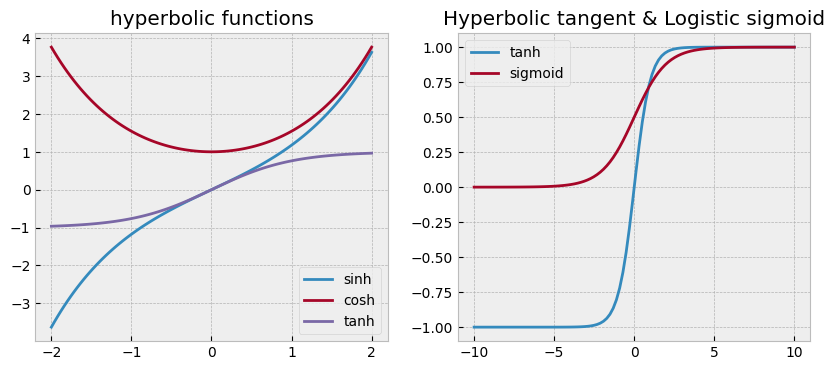

In [5]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
x = np.linspace(-2,2,100)
plt.plot(x,np.sinh(x), label="sinh")
plt.plot(x,np.cosh(x), label="cosh")
plt.plot(x,np.tanh(x), label="tanh")
plt.legend()
plt.title("hyperbolic functions")

plt.subplot(1,2,2)
x = np.linspace(-10,10,100)
plt.plot(x,np.tanh(x), label="tanh")
plt.plot(x, (lambda x: 1/(1+np.exp(-x)))(x), label="sigmoid")
plt.legend()
plt.title("Hyperbolic tangent & Logistic sigmoid")
plt.show()

### フォワードプロパゲーションの流れ

上述した通り，ここで紹介するRNNでは時間方向の影響をモデル化した隠れ層を利用しています．これを使ったRNNフォワードプロパゲーションの全体像を見ておきましょう．$f$と$g$は任意の活性化関数です．


$$
\begin{align}
&\text{input layer: } \quad  x_t \\
&\text{hidden layer:} \quad h_{t} = \operatorname{f}(x_{t}\cdot {W^{(x,h)}} + h_{t-1}\cdot W^{(h,h)}+b^{x,h}) \\
&\text{output layer:} \quad o_{t} = \operatorname{g}(h_t \cdot W^{(h,o)}+b^{(h,o)})
\end{align}
$$


:::{hint}

例えば文書生成などがRNNを使う例として考えられます．入力データとして，ある文書に登場する単語一つ一つを$x_1,x_2,\cdots,x_{T-1}$として入力して，それぞれの出力を$\hat{x_2},\hat{x_3},\cdots, \hat{x_T}$としましょう．この時出力値はそれぞれ「入力された単語の次に出現する単語」に相当します．

:::

（以下は疑似コードの形の方が理解しやすい人向け）

RNNの疑似コード {prf:ref}`rnn-forward-prop`を作るために，以下の様に定義します．

- $M$: バッチサイズ
- $T$: 時間
- $K$: 特徴数
- $C$: クラス数
- $H$: 隠れ層の次元数


また，$\operatorname{softmax}$は最もネストの深い軸（axis=-1）を基準に計算しているとします．

::::{prf:algorithm} Forward propagation of RNN
:label: rnn-forward-prop

**Input:** $\mathbf{X} \in \mathbb{R}^{M \times T \times K}$: mini-batch データ, $\Theta$: モデルパラメータの集合

ここで, $\Theta$には以下のパラメータが含まれている．

- $\mathbf{W}^{(x,h)} \in \mathbb{R}^{K \times H}$: 入力層→隠れ層の重み
- $\mathbf{W}^{(h,h)} \in \mathbb{R}^{H \times H}$: 隠れ層→隠れ層の重み
- $\mathbf{W}^{(h,o)} \in \mathbb{R}^{H \times C}$: 隠れ層→出力層の重み
- $\mathbf{b}^{(x,h)} \in \mathbb{R}^{H}$: 入力層→隠れ層のバイアス
- $\mathbf{b}^{(h,o)} \in \mathbb{R}^{C}$: 隠れ層→出力層のバイアス

**Output:** $\hat{\mathbf{Y}} \in \mathbb{R}_{>0}^{M \times T \times C}$: 各クラスへの所属確率

1. 全ての要素を0で初期化 
    $\mathbf{H} \leftarrow \mathbf{O} \in \mathbb{R}^{M \times T \times H}$
2. $\hat{\mathbf{H}}_{0} \leftarrow \mathbf{O} \in \mathbb{R}^{M \times H}$
3. **For** $t = 1:T$ **do**:
4. &nbsp;&nbsp;&nbsp;&nbsp;$t$時点の隠れ層出力を算出 $\hat{\mathbf{H}}_{t} \leftarrow \operatorname{tanh}(\mathbf{X}_{:,t,:} \cdot \mathbf{W}^{(x,h)}+\mathbf{h}_{t-1}\cdot \mathbf{W}^{(h,h)} + \mathbf{b}^{(x,h)})$
5. &nbsp;&nbsp;&nbsp;&nbsp;全ての時点の出力を一つの配列に保存 $\mathbf{H}_{:,t,:} \leftarrow \hat{\mathbf{H}}_{t}$     
6. 出力を算出
    $\hat{\mathbf{Y}} \leftarrow \operatorname{softmax}(\mathbf{H} \cdot  \mathbf{W}^{(h,o)} + \mathbf{b}^{(h,o)})$

::::

## BPTT（Backpropagation through time）

学習ではunfold（展開）したネットワークに対して，一番最後の出力から遡ってBack Propagationしていきます．この手法のことを __Back Propagation Through Time（BPTT）__ と呼びます．

> ![](https://camo.qiitausercontent.com/b0c4040112f747cc634270019bfb3b91b0f88f6e/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e61702d6e6f727468656173742d312e616d617a6f6e6177732e636f6d2f302f3536383638382f33396539396631322d303561632d383831312d663663332d6461383962316538396565362e706e67)  
[出典: PyTorchを使ってジャパリパークの歌詞みたいなやつを生成させたい](https://qiita.com/kibounoasa/items/78fb5a217232de863b00)


パラメータの更新は以下のように行います：

$$
\begin{aligned}
\mathrm{w}_{\mathrm{ji}}^{(\mathrm{l}) \text { new }} & =\mathrm{w}_{\mathrm{ji}}^{(\mathrm{l}) \text { old }}-\eta \frac{\partial \mathrm{L}}{\partial \mathrm{W}_{\mathrm{ji}}^{(l)}} \\
\mathrm{w}_{\mathrm{jj}}^{(\mathrm{l}) \text { new }} & =\mathrm{w}_{\mathrm{jj}}^{(\mathrm{l}) \text {,old }}-\eta \frac{\partial \mathrm{L}}{\partial \mathrm{w}_{\mathrm{jj}}^{(l)}} \\
\mathrm{L} & =\sum_{\mathrm{t}=1}^T \mathrm{~L}^{(\mathrm{t})}
\end{aligned}
$$

損失関数は全ての出力値から計算したものを合計して利用します．それ以外は普通のMLPと同様です．

- BPTTの利点
    - これまでのMLPの訓練方法の通りである
- BPTTの欠点
    - 計算グラフが大きくなるので勾配消失問題や勾配爆発問題が起こりやすい
    
この問題を解決するために，ある程度遡ったら途中で勾配を切り捨てる様なBPTTの拡張として，__Truncated BPTT__ が提案されています．

> ![](https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.ap-northeast-1.amazonaws.com%2F0%2F568688%2Faace0b89-3603-bfcd-5cbe-307f55fc0049.png?ixlib=rb-4.0.0&auto=format&gif-q=60&q=75&w=1400&fit=max&s=779bd53f95eef72ccd37d19819cd4c69)  
[出典: PyTorchを使ってジャパリパークの歌詞みたいなやつを生成させたい](https://qiita.com/kibounoasa/items/78fb5a217232de863b00)


遡るタイムステップ数 $\tau$ を限定したBPTTを Truncated BPTT といいます。

- Truncated BPTTの利点
    - 勾配消失や勾配爆発をある程度抑制できる．
- Truncated BPTTの欠点
    - 任意の範囲で勾配履歴を切り落としてしまう．

## 例：文書生成モデル

### データローダー

In [6]:
with open("./data/ja.text8") as f:
    text8 = f.read()

import re
def build_simply_dictionary(texts):
    token_set = set(token for text in texts for token in text.split())
    word2id = {token:id for id, token in enumerate(token_set)}  
    return word2id

def my_analyzer(text):
    #text = code_regex.sub('', text)
    tokens = text.split()
    tokens = filter(lambda token: re.search(r'[ぁ-ん]+|[ァ-ヴー]+|[一-龠]+', token), tokens)
    return tokens 

def build_dictionary(texts, min_df=1):
    from sklearn.feature_extraction.text import CountVectorizer
    countvectorizer = CountVectorizer(min_df=min_df, analyzer=my_analyzer)

    X = countvectorizer.fit_transform(texts)
    id2word = {id:w for id,w in enumerate(countvectorizer.get_feature_names_out())}
    word2id = {w:id for id,w in id2word.items()}
    return id2word, word2id, X

texts = text8.split("。")
id2word, word2id,X = build_dictionary(texts,5)
V = len(id2word)
D = len(texts)
print(f"文書数: {D}, 語彙数: {V}")

WINDOW_SIZE = 11

preprocessed_texts = [[word2id[w] for w in text.split() if w in word2id] for text in texts]
preprocessed_texts = [text for text in preprocessed_texts if len(text) > WINDOW_SIZE]

文書数: 564194, 語彙数: 63269


In [7]:
def make_word2id_seq(corpus ,word2id, max_length=10):
    tmp = []
    for doc in corpus:
        line = [word2id[w] for w in doc.split() if w in word2id]
        # もしmax_lengthよりも単語数が多ければ切り捨て，
        if len(line) >= max_length:
            line = line[:max_length]
        # もしmax_lengthよりも単語数が少なければ0で穴埋め,
        elif len(line) <= max_length:
            line += [0]* (max_length - len(line))
        tmp.append(line)
    return tmp 

def make_id2word_seq(id_seqs, id2word):
    tmp = []
    for id_seq in id_seqs:
        line = [id2word[id] for id in id_seq  if id in id2word]
        tmp.append(" ".join(line))
    return tmp

In [8]:
class MyDataset(Dataset):
    def __init__(self, id_data):
        super().__init__()
        self.data_length = len(id_data)
        # 訓練データ。例：［'僕', 'は', 'カレー', 'が', '好き']
        self.x = [row[0:-1] for row in id_data]
        # 正解ラベル。例：['は', 'カレー', 'が', '好き', '。']
        self.y = [row[1:] for row in id_data]
    
    def __len__(self):
        return self.data_length
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])

In [9]:
BS = 2
dataset = MyDataset(make_word2id_seq(texts, word2id))
dl = DataLoader(dataset, batch_size=BS, shuffle=True, drop_last=True)

### 文書生成RNNの作成

In [12]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, batch_size, num_layers=1) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True, num_layers=self.num_layers)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def init_hidden(self, batch_size=None):
        if not batch_size:
            batch_size = self.batch_size
        self.hidden_state = torch.zeros(self.num_layers, batch_size,
                                        self.hidden_size).to(self.device)

    def forward(self, x):
        x = self.embedding(x)
        x, self.hidden_state = self.rnn(x, self.hidden_state)
        x = self.fc(x)
        return x


### 訓練スクリプト

In [13]:
EMBEDDING_DIM = 300
HIDDEN_SIZE = 300
NUM_LAYERS = 1
VOCAB_SIZE = len(word2id)# + 1

def train(model, dataloader, criterion, optimizer, epochs, vocab_size):
    device = model.device
    model.train()
    losses = []

    for epoch in range(EPOCHS):
        running_loss = 0
        for cnt, batch in enumerate(dataloader):
            (X_train, y_train) = batch
            optimizer.zero_grad()
            X_train, y_train = X_train.to(device), y_train.to(device)
            model.init_hidden()
            outputs = model(X_train)
            outputs = outputs.reshape(-1, vocab_size)
            y_train = y_train.reshape(-1)
            loss = criterion(outputs, y_train)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        losses.append(running_loss / cnt)

        print('+', end='')
        if epoch % 50 == 0:
            print(f'\nepoch: {epoch:3}, loss: {loss:.3f}')

    print(f'\nepoch: {epoch:3}, loss: {loss:.3f}')
    return losses

# 実行は以下のコードを叩くことで可能です．

EPOCHS = 1
model = RNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE, BS, NUM_LAYERS)
BS = 2
dataset = MyDataset(make_word2id_seq(texts, word2id))
dataloader = DataLoader(dataset, batch_size=BS, shuffle=True, drop_last=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

losses = train(model, dataloader, criterion, optimizer, EPOCHS, VOCAB_SIZE)

KeyboardInterrupt: 

言語モデルの学習には非常に時間がかかります．寝る前に回してみましょう．